In [518]:
import numpy as np
from scipy import stats, random
import pylab as plt
from itertools import compress
from tqdm import tqdm

import pylab as plt

In [537]:
# Datastore with N samples from normal distribution

class DataStore:
    def __init__(self, x = None, z = None, u = None):
        """Initialize datastore content. Default is empty."""
        # Initialize datastore content
        self.x = x # samples
        self.z = z # samples
        self.u = lambda z: 0.  # intensity function
        
    def __len__(self):
        """Number of samples in the datastore."""
        if self.z is not None:
            return len(self.z)
        else:
            return 0

    def _max_u(self, u):
        """Replace DS intensity function with max between intensity functions."""
        if self.u is None:
            self.u = u
        else:
            self.u = lambda z, u_prev = self.u: max(u_prev(z), u(z))
    
    def _append(self, x, z):
        """Append (x, z) to datastore content."""
        if x is None:
            x = [None for i in range(len(z))]
        if self.x is None:
            self.x = x
            self.z = z
        else:
            self.x += x
            self.z = np.vstack([self.z, z])
            
    def grow(self, mu, p):
        """Grow number of samples in datastore."""
        
        # Number of requested samples from p
        N = np.random.poisson(mu, 1)[0]
        
        # Proposed new samples z from p
        z_prop = p.sample(N)
        
        # Rejection sampling from proposal list
        accepted = []
        for z in tqdm(z_prop, desc = "Adding samples."):
            rej_prob = np.minimum(1, self.u(z)/mu/p.pdf(z))
            w = np.random.rand(1)[0]
            accepted.append(rej_prob < w)
        z_accepted = z_prop[accepted, :]
        print("Adding %i new samples."%len(z_accepted))
        
        # Add new entries to datastore and update intensity function
        self._append(None, z_accepted)
        self._max_u(lambda z: mu*p.pdf(z))
        
    def sample(self, mu, p):
        accepted = []
        if self.z is None:
            print("Warning: Requires running grow!")
            return None, None
        for z in tqdm(self.z, desc = "Extracting samples."):
            accept_prob  = mu*p.pdf(z)/self.u(z)
            if accept_prob > 1.:
                print("Warning: Requires running grow!")
                return None, None
            w = np.random.rand(1)[0]
            accepted.append(accept_prob > w)
        x_sub = list(compress(self.x, accepted))
        z_sub = self.z[accepted, :]
        if any([x is None for x in x_sub]):
            print("Warning: Requires simulator run!")
            x_sub = None
        return x_sub, z_sub
    
    def get_z_without_x(self):
        return self.z[[x is None for x in self.x]]
    
    def fill_sims(self, x, z):
        for i in tqdm(range(len(z)), desc = "Adding simulations"):
            j = np.where((self.z == z[i]).all(axis=1))[0][0]
            self.x[j] = x[i]

In [538]:
class Prior:
    def __init__(self, z0, z1):
        self.z0 = np.array(z0)
        self.z1 = np.array(z1)
        
    def sample(self, N):
        q = np.random.rand(N, len(self.z0))
        q *= self.z1 - self.z0
        q += self.z0
        return q

    def pdf(self, z):
        if any(z < self.z0) or any(z > self.z1):
            return 0.
        else:
            return 1./(self.z1 - self.z0).prod()

In [608]:
ds = DataStore()
p0 = Prior([0.0, 0.0], [1.0, 1.0])
p1 = Prior([0.4, 0.4], [0.5, 0.5])
p2 = Prior([0.4, 0.4], [0.6, 0.6])
ds.grow(1000, p0)
ds.grow(1000, p1)
ds.grow(1000, p2)

Adding samples.: 100%|██████████| 943/943 [00:00<00:00, 22515.23it/s]

Adding 1011 new samples.
Adding 955 new samples.
Adding 660 new samples.


Extracting samples.: 100%|██████████| 2626/2626 [00:00<00:00, 17069.75it/s]


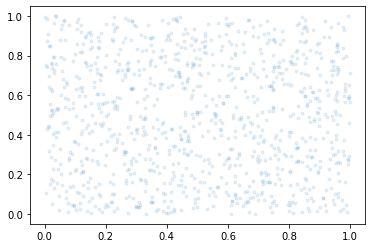

In [609]:
x, z = ds.sample(1000, p0)
#z = ds.z
plt.scatter(z[:,0], z[:,1], marker='.', alpha = 0.1)

In [610]:
z = ds.get_z_without_x()
x = list(np.sin(z))  # Toy data
ds.fill_sims(x, z)

Adding simulations: 100%|██████████| 2626/2626 [00:00<00:00, 10141.46it/s]


In [611]:
x, z = ds.sample(1000, p0)
x, z = ds.sample(1000, p1)
x, z = ds.sample(1000, p2)

Extracting samples.: 100%|██████████| 2626/2626 [00:00<00:00, 21930.28it/s]


In [612]:
x, z = ds.sample(1100, p1)

Extracting samples.:   6%|▌         | 147/2626 [00:00<00:00, 22252.15it/s]